# Short-term Load Forecasting using BiLSTM


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Libraries

In [ ]:
import numpy as np
from math import sqrt
from pandas import read_csv
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import make_interp_spline
from matplotlib import rcParams

from keras.callbacks import CSVLogger
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.backend import dropout

from statsmodels.tsa.seasonal import seasonal_decompose

## Model Training and Evaluation and Other Helper Functions

In [ ]:
# split  dataset into train, validate and test sets
def split_dataset(data):
	# split into train validation and test sets
	train, val, test = data[12:13932], data [13932:18300], data[18300:22716]
	# restructure into samples of daily data shape is [samples, hours, feature]
	train = np.array(np.split(train, len(train)/24))
	val = np.array(np.split(val, len(val)/24))
	test = np.array(np.split(test, len(test)/24))
	return train, val, test

# evaluate one or more daily forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each hour of the day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store in scores list
		scores.append(rmse)
  
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.2f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs (actual) and outputs (predicted) for training
def convert_train_val(train, n_input, n_out=24):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step of 1 hour
		in_start += 1
	return np.array(X), np.array(y)

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1] that is 1 sample, sample data size, one feature
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next hour
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# Build and train BiLSTM model
def build_model_BiLSTM(train, val, n_input):
	# Create training and validation sets
	train_x, train_y = convert_train_val(train, n_input)
	val_x, val_y = convert_train_val(val, n_input)
	# define parameters
	csv_logger = CSVLogger('BiLSTM_Model_Logger.log')
	verbose, epochs, batch_size = 0, 30, 384
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	nv_timesteps, nv_features, nv_outputs = val_x.shape[1], val_x.shape[2], val_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	val_y = val_y.reshape((val_y.shape[0], val.shape[1], 1))
	# define model
	model = Sequential()
	model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True), input_shape=(n_timesteps, 1)))
	model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	print(model.summary())
	# fit network and store mse loss in hist 
	hist=model.fit(train_x, train_y, validation_data=(val_x, val_y),callbacks=[csv_logger], epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model, hist

# evaluate model fits model using training and validation data, then conducts a walk forwad validation with the test data
def evaluate_model_BiLSTM(train, val, test, n_input):
	# fit model
	model, hist = build_model_BiLSTM(train, val, n_input)
	# history is a list of houry data
	history = [x for x in train]
	# walk-forward validation over each hour in test set
	predictions = list()
	for i in range(len(test)):
		# predict the hour
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next hour
		history.append(test[i, :])
	# evaluate predictions hours for each day
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, hist, predictions

## Load Dataset

In [ ]:
dataset = read_csv('/content/drive/MyDrive/data_spatial_TotalKW.csv', header=0, 
                   infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

#### Decompose data into trend, seasonality, and noise

<Figure size 432x288 with 0 Axes>

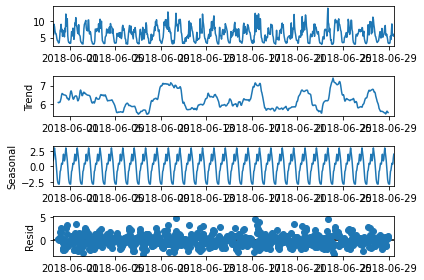

In [ ]:
%matplotlib inline
fig1 = plt.gcf()
month = dataset.iloc[0:720]
decomp = seasonal_decompose(month, model='additive')
decomp.plot()
plt.show()
fig1.savefig('seasonal_decompose.pdf')

#### Normalization - normalize data using min-max scaling

In [ ]:
trans = MinMaxScaler()
dataset = trans.fit_transform(dataset)
tran_scale = trans.scale_

# split into train and test
train, val, test = split_dataset(dataset)
print('train size: ', train.shape)
print('valid size: ', val.shape)
print('test size : ', test.shape)

train size:  (580, 24, 1)
valid size:  (182, 24, 1)
test size :  (184, 24, 1)


## Naive Prediction

N_actual size:  (183, 24, 1)
Avg. score: 1.79
rmse: [1.787] 0.50, 0.48, 0.50, 0.71, 1.15, 1.53, 1.45, 2.05, 2.54, 2.59, 3.09, 2.36, 2.38, 2.13, 2.09, 2.26, 2.44, 1.98, 1.59, 1.49, 1.14, 0.84, 0.72, 0.61


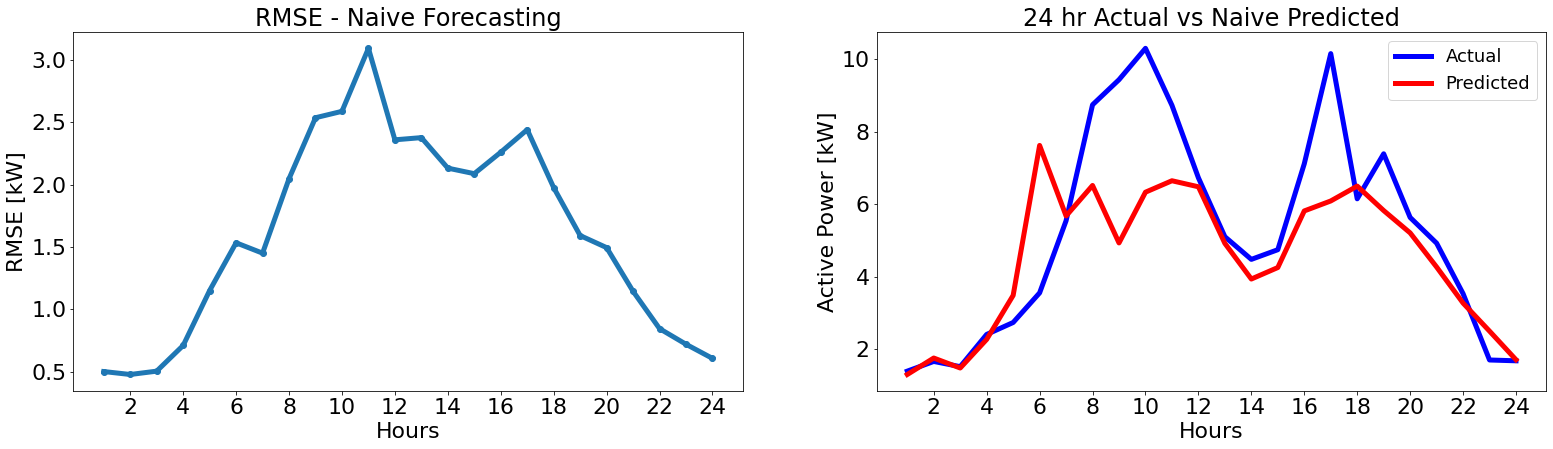

In [ ]:
plt.rcParams.update({'font.size': 14})

# Perform naive prediction
N_actual= test[1:184] / tran_scale
N_predicted = test[0:183] / tran_scale 

N_score, N_scores = evaluate_forecasts(N_actual, N_predicted)

print('N_actual size: ', N_actual.shape)
print('Avg. score: {:.2f}'.format(N_score))

# summarize rmse scores
summarize_scores('rmse', N_score, N_scores)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6*2*2.2, 3*2.2))

# plot rmse scores
hours = ['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12','13', '14', '15', '16', '17', '18', '19','20', '21', '22', '23', '24' ]
axs[0].plot(hours, N_scores, marker='o', label='lstm', linewidth=5)
axs[0].set_title('RMSE - Naive Forecasting', fontsize=24)
axs[0].set_xlabel("Hours", fontsize=22)
axs[0].set_ylabel("RMSE [kW]", fontsize=22)
axs[0].set_xticks(np.arange(1, len(hours), 2))
# axs[0].set_yticks(np.arange(1, max(y), 25))
axs[0].tick_params(axis='x', labelsize=22)
axs[0].tick_params(axis='y', labelsize=22)

# plot an example prediction for one day
axs[1].plot(hours, N_actual[15], 'b', label='Actual', linewidth=5)
axs[1].plot(hours, N_predicted[15], 'r', label='Predicted', linewidth=5)
axs[1].set_title('24 hr Actual vs Naive Predicted', fontsize=24)
axs[1].set_xlabel("Hours", fontsize=22)
axs[1].set_ylabel("Active Power [kW]", fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(np.arange(1, len(hours), 2))
# axs[1].set_yticks(np.arange(1, max(y), 25))
axs[1].tick_params(axis='x', labelsize=22)
axs[1].tick_params(axis='y', labelsize=22)

### SAVE PLOTS
# Save just the portion _inside_ the second axis's boundaries
extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# Pad area by 30% in the x-direction and 20% in the y-direction for full axes visibility
fig.savefig('rmse-Naive.pdf', bbox_inches=extent.expanded(1.2, 1.3))

extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('prediction-Naive.pdf', bbox_inches=extent.expanded(1.2, 1.3))

## Evaulate BiLSTM model and get scores

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 24, 400)          323200    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 24, 200)          400800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 24, 100)          20100     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 24, 1)            101       
 tributed)                                                       
                                                                 
Total params: 744,201
Trainable params: 744,201
Non-tr

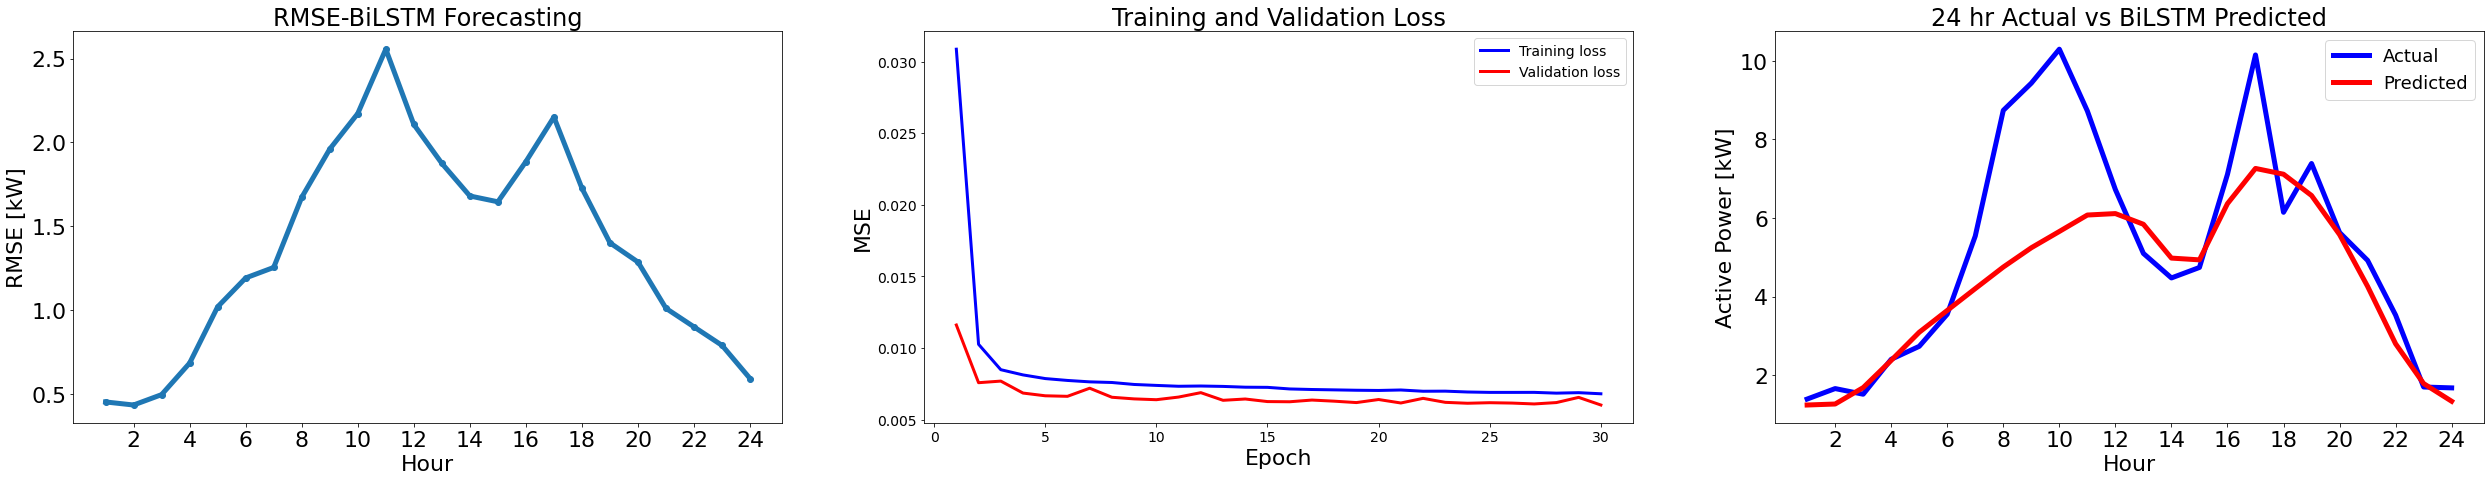

In [ ]:
# evaluate model and get scores
n_input = 24
BL_score, BL_scores, hist_BL, predictions_BL = evaluate_model_BiLSTM(train, val, test, n_input)
BL_score, BL_scores, predictions_BL = BL_score/tran_scale , BL_scores/tran_scale, predictions_BL/tran_scale
# summarize rmse scores
summarize_scores('rmse', BL_score, BL_scores)
print('Avg. score: ', BL_score)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6*3*2.4, 3*2.4))

# plot rmse scores
hours = ['1', '2', '3', '4', '5', '6', '7','8', '9', '10', '11', '12','13', '14', '15', '16', '17', '18', '19','20', '21', '22', '23', '24' ]
axs[0].plot(hours, BL_scores, marker='o', label='BiLSTM', linewidth=5)
axs[0].set_title('RMSE-BiLSTM Forecasting', fontsize=24)
axs[0].set_xlabel("Hour", fontsize=22)
axs[0].set_ylabel("RMSE [kW]", fontsize=22)
axs[0].set_xticks(np.arange(1, len(hours), 2))
axs[0].tick_params(axis='x', labelsize=22)
axs[0].tick_params(axis='y', labelsize=22)

extent = axs[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('RMSE-BiLSTM.pdf', bbox_inches=extent.expanded(1.2, 1.3))

# Plot training and validation loss
loss = hist_BL.history['loss']
val_loss = hist_BL.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[1].plot(epochs, loss, 'b', label='Training loss', linewidth=3)
axs[1].plot(epochs, val_loss, 'r', label='Validation loss', linewidth=3)
axs[1].set_title('Training and Validation Loss', fontsize=24)
axs[1].set_xlabel("Epoch", fontsize=22)
axs[1].set_ylabel("MSE", fontsize=22)
axs[1].legend()

extent = axs[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('train-val-loss-BiLSTM.pdf', bbox_inches=extent.expanded(1.3, 1.3))

# Plot an example prediction for one day
axs[2].plot(hours, N_actual[15], 'b', label='Actual', linewidth=5)
axs[2].plot(hours, predictions_BL[15], 'r', label='Predicted', linewidth=5)
axs[2].set_title('24 hr Actual vs BiLSTM Predicted', fontsize=24)
axs[2].set_xlabel("Hour", fontsize=22)
axs[2].set_ylabel("Active Power [kW]", fontsize=22)
axs[2].legend(fontsize=18)
axs[2].set_xticks(np.arange(1, len(hours), 2))
axs[2].tick_params(axis='x', labelsize=22)
axs[2].tick_params(axis='y', labelsize=22)

extent = axs[2].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('predictions-BiLSTM.pdf', bbox_inches=extent.expanded(1.2, 1.3))